In [2]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator
#import tmap as tm


#from mobius import ForceField, VirtualTarget

In [8]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(300 * 1e-9)

-8.953114032261194

In [319]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [320]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [7]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [219]:
import itertools
from collections import defaultdict

import tmap as tm
from mhfp.encoder import MHFPEncoder
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem.rdmolops import GetDistanceMatrix


def to_smiles(mol):
    return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)


class MAP4Calculator:

    def __init__(self, dimensions=1024, radius=2, is_counted=False, is_folded=False, return_strings=False):
        """
        MAP4 calculator class
        """
        self.dimensions = dimensions
        self.radius = radius
        self.is_counted = is_counted
        self.is_folded = is_folded
        self.return_strings = return_strings

        if self.is_folded:
            self.encoder = MHFPEncoder(dimensions)
        else:
            self.encoder = tm.Minhash(dimensions)

    def calculate(self, mol):
        """Calculates the atom pair minhashed fingerprint
        Arguments:
            mol -- rdkit mol object
        Returns:
            tmap VectorUint -- minhashed fingerprint
        """
        
        atom_env_pairs = self._calculate(mol)
        if self.is_folded:
            return self._fold(atom_env_pairs)
        elif self.return_strings:
            return atom_env_pairs
        return self.encoder.from_string_array(atom_env_pairs)

    def calculate_many(self, mols):
        """ Calculates the atom pair minhashed fingerprint
        Arguments:
            mols -- list of mols
        Returns:
            list of tmap VectorUint -- minhashed fingerprints list
        """

        atom_env_pairs_list = [self._calculate(mol) for mol in mols]
        if self.is_folded:
            return [self._fold(pairs) for pairs in atom_env_pairs_list]
        elif self.return_strings:
            return atom_env_pairs_list
        return self.encoder.batch_from_string_array(atom_env_pairs_list)

    def _calculate(self, mol):
        return self._all_pairs(mol, self._get_atom_envs(mol))
    
    def counted_fold(self, hash_values, length=2048):
        """Folds the hash values to a binary vector of a given length.
        Arguments:
          hash_value {numpy.ndarray} -- An array containing the hash values.
          length {int} -- The length of the folded fingerprint (default: {2048})

        Returns:
          numpy.ndarray -- The folded fingerprint.
        """
        folded = np.zeros(length, dtype=np.uint8)
        
        positions, counts = np.unique(hash_values % length, return_counts=True)
        folded[positions] = counts
        
        #folded[hash_values % length] += 1

        return folded

    def _fold(self, pairs):
        fp_hash = self.encoder.hash(set(pairs))
        
        if self.is_counted:
            fp_folded = self.counted_fold(fp_hash, self.dimensions)
        else:
            fp_folded = self.encoder.fold(fp_hash, self.dimensions)
        
        return fp_folded

    def _get_atom_envs(self, mol):
        atoms_env = {}
        for atom in mol.GetAtoms():
            idx = atom.GetIdx()
            for radius in range(1, self.radius + 1):
                if idx not in atoms_env:
                    atoms_env[idx] = []
                atoms_env[idx].append(MAP4Calculator._find_env(mol, idx, radius))
        return atoms_env

    @classmethod
    def _find_env(cls, mol, idx, radius):
        env = rdmolops.FindAtomEnvironmentOfRadiusN(mol, radius, idx)
        atom_map = {}

        submol = Chem.PathToSubmol(mol, env, atomMap=atom_map)
        if idx in atom_map:
            smiles = Chem.MolToSmiles(submol, rootedAtAtom=atom_map[idx], canonical=True, isomericSmiles=False)
            return smiles
        return ''

    def _all_pairs(self, mol, atoms_env):
        atom_pairs = []
        distance_matrix = GetDistanceMatrix(mol)
        num_atoms = mol.GetNumAtoms()
        shingle_dict = defaultdict(int)
        
        for idx1, idx2 in itertools.combinations(range(num_atoms), 2):
            dist = str(int(distance_matrix[idx1][idx2]))

            for i in range(self.radius):
                env_a = atoms_env[idx1][i]
                env_b = atoms_env[idx2][i]

                ordered = sorted([env_a, env_b])

                shingle = '{}|{}|{}'.format(ordered[0], dist, ordered[1])

                if self.is_counted:
                    shingle_dict[shingle] += 1
                    shingle += '|' + str(shingle_dict[shingle])

                atom_pairs.append(shingle.encode('utf-8'))
        
        return list(set(atom_pairs))

In [220]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_counted=False, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

## Load dataset

In [9]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [10]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (~mhci['affinity_binding'].isin(dirty_values))]

In [11]:
decoys = []

with open('uniprot_sprot.fasta') as f:
    lines = f.readlines()
    
    sequence = ''
    
    for line in lines:
        if line.startswith('>'):
            if sequence != '':
                decoys.append((sequence, len(sequence)))
            sequence = ''
        else:
            sequence += line.strip()
        
    decoys.append((sequence, len(sequence)))
    
decoys = pd.DataFrame(data=decoys, columns=('sequence', 'length'))

mhci_decoys = decoys[(decoys['length'] >= 5) & (decoys['length'] <= 20)].copy()
# Remove peptide with unknow amino acids
mhci_decoys = mhci_decoys[~mhci_decoys['sequence'].str.contains('X|Z|B|U', regex=True)]
mhci_decoys['energy'] = 0.

print('Number of decoy peptides: %d' % mhci_decoys.shape[0])

Number of decoy peptides: 3372


## Random train-test (70/30) split (ALL SIZE PEPTIDE)

### MAP4 fingerprint + Tanimoto kernel

In [482]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(5956,) (2553,)


In [483]:
model = get_fitted_model(X_train_fps, y_train)

R2   : 0.599
RMSD : 1.223 kcal/mol


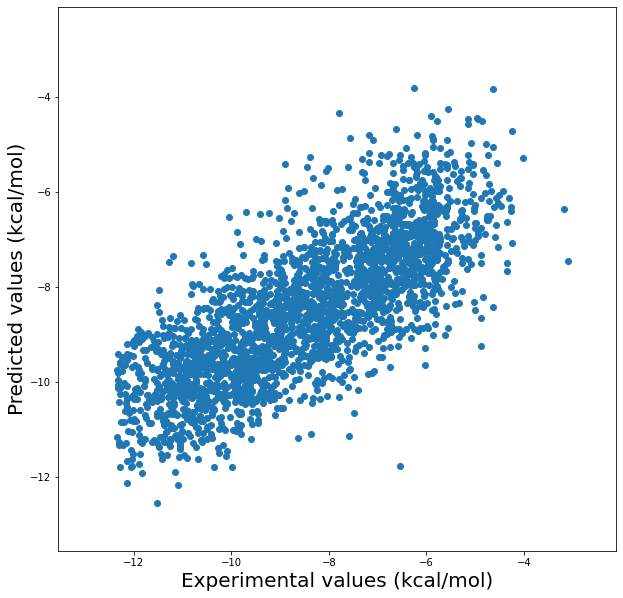

In [485]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_all_size_pep.png')

### MAP4 counter fingerprint + MinMax kernel

In [222]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train, is_counted=True)
X_test_fps = map4_fingerprint(X_test, is_counted=True)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(5956,) (2553,)


In [330]:
class MinMaxKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_eq_x2 = torch.equal(x1, x2)
        
        if diag and x1_eq_x2:
            res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
            return res
        
        minkernel = torch.zeros(x1.shape[-2], x2.shape[-2], dtype=x1.dtype, device=x1.device)
        maxkernel = torch.zeros(x1.shape[-2], x2.shape[-2], dtype=x1.dtype, device=x1.device)
     
        for d in range(x1.shape[-1]):
            minkernel += torch.minimum(x1[:, d, None], x2[:, d])
            maxkernel += torch.maximum(x1[:, d, None], x2[:, d])
        
        res = minkernel / maxkernel
        
        if diag:
            # Lazy and not optimal...
            res = res.diag()
        
        return res

In [331]:
model = get_fitted_model(X_train_fps, y_train, kernel=MinMaxKernel)

KeyboardInterrupt: 

In [ ]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_counted_fps_minmax_mhc-i_cleaned_all_size_pep.png')

In [329]:
k = MinMaxKernel()
m = k.forward(X_train_fps, X_train_fps, diag=True)
print(m)

tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [262]:
k = TanimotoSimilarityKernel()
m = k.forward(X_train_fps[:10], X_train_fps[:10])
print(m)

tensor([[1.0000, 0.6197, 0.5609, 0.5692, 0.5793, 0.5845, 0.5553, 0.6617, 0.5768,
         0.5822],
        [0.6197, 1.0000, 0.5398, 0.5782, 0.5508, 0.6765, 0.5732, 0.6320, 0.5064,
         0.5043],
        [0.5609, 0.5398, 1.0000, 0.6080, 0.6096, 0.5041, 0.5032, 0.5480, 0.5839,
         0.5525],
        [0.5692, 0.5782, 0.6080, 1.0000, 0.5555, 0.5824, 0.5842, 0.6087, 0.5548,
         0.5044],
        [0.5793, 0.5508, 0.6096, 0.5555, 1.0000, 0.4965, 0.4899, 0.5297, 0.5656,
         0.5253],
        [0.5845, 0.6765, 0.5041, 0.5824, 0.4965, 1.0000, 0.6189, 0.6156, 0.4884,
         0.4742],
        [0.5553, 0.5732, 0.5032, 0.5842, 0.4899, 0.6189, 1.0000, 0.6457, 0.5211,
         0.5111],
        [0.6617, 0.6320, 0.5480, 0.6087, 0.5297, 0.6156, 0.6457, 1.0000, 0.5682,
         0.5738],
        [0.5768, 0.5064, 0.5839, 0.5548, 0.5656, 0.4884, 0.5211, 0.5682, 1.0000,
         0.6157],
        [0.5822, 0.5043, 0.5525, 0.5044, 0.5253, 0.4742, 0.5111, 0.5738, 0.6157,
         1.0000]])


# Bayesian opt. prototype

In [12]:
# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = map4_fingerprint(mhci['sequence'].values)
y_exp = torch.from_numpy(mhci['energy'].values).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (8509, 4096)


In [13]:
# Compute the MAP4 fingerprint for all the DECOY peptides
X_fps_decoys = map4_fingerprint(mhci_decoys['sequence'].values)
y_decoys = torch.from_numpy(mhci_decoys['energy'].values).float()

print('Decoys dataset size: (%d, %d)' % (X_fps_decoys.shape[0], X_fps_decoys.shape[1]))

Decoys dataset size: (3372, 4096)


In [14]:
X_fps = torch.cat([X_fps_exp, X_fps_decoys])
y = torch.cat([y_exp, y_decoys])

print('Full dataset size: (%d, %d)' % (X_fps.shape[0], X_fps.shape[1]))

Full dataset size: (11881, 4096)


In [50]:
k = TanimotoSimilarityKernel()
mat = 1. - k.forward(X_fps, X_fps)

fit = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='precomputed')
u = fit.fit_transform(mat)

np.savetxt('umap_embedding_exp_decoys.csv', u, delimiter=',')

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


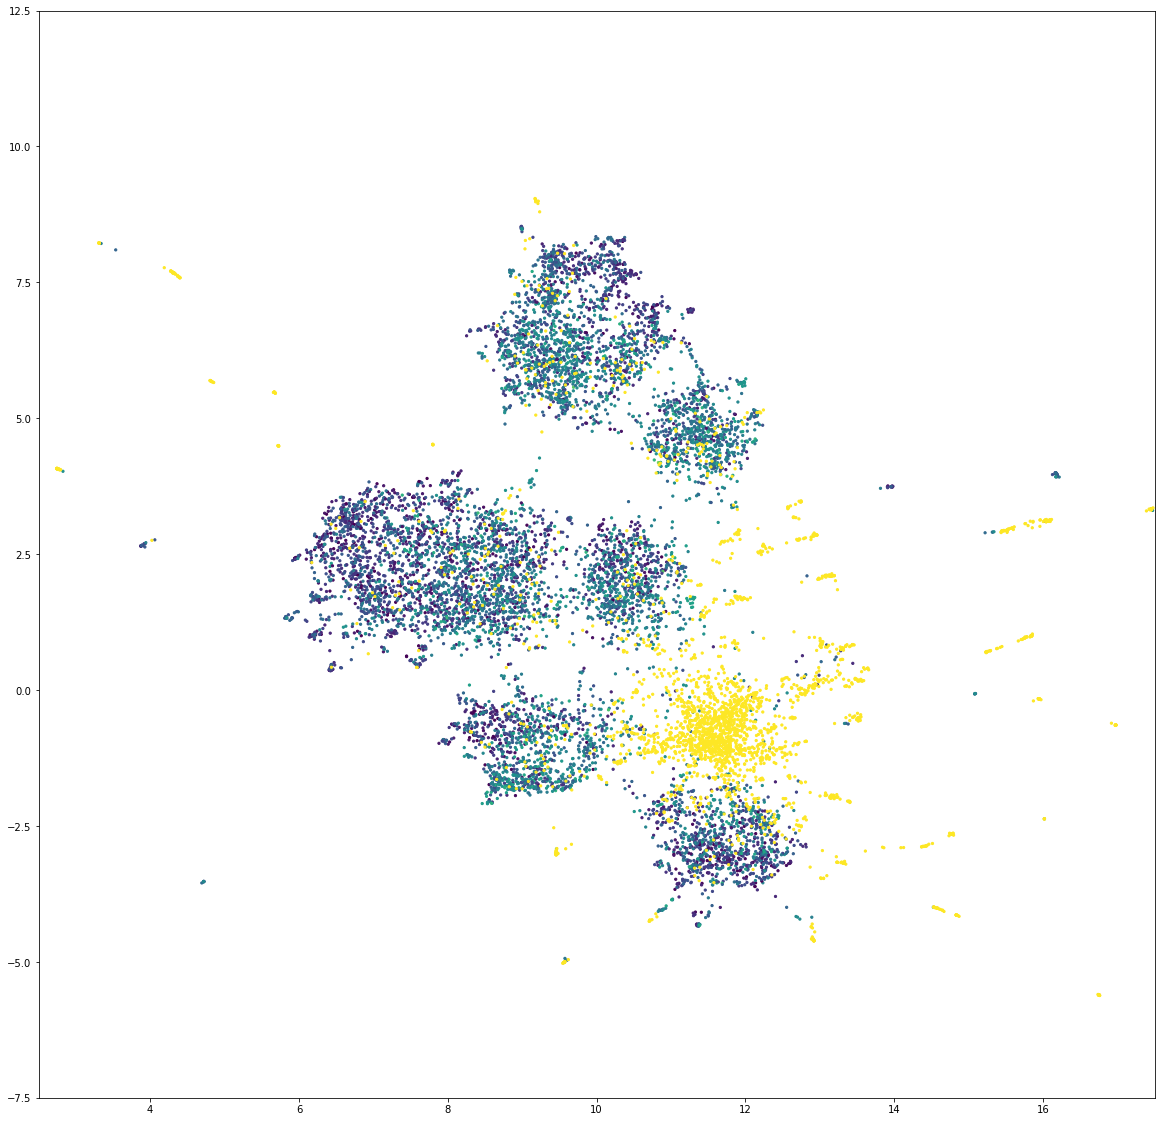

In [56]:
xlim = [2.5, 17.5]
ylim = [-7.5, 12.5]
u = np.genfromtxt('umap_embedding_exp_decoys.csv', delimiter=',')

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

## ALL + Random low affinity binding peptides

In [58]:
# Select n_training (here 150) low affinity binding peptides (energy > -8.5) for the initial training set
# The other peptides will constitute the peptides pool fro, where we will draw the candidates during the otimization

energy_cutoff = -8.5
n_training = 150

low_affinity_ids = np.where(y_exp.numpy() >= energy_cutoff)[0]
high_affinity_ids = np.where(y_exp.numpy() < energy_cutoff)[0]
decoy_ids = np.arange(len(y_exp), len(y_exp) + len(y_decoys))

print('Low affinity : %d' % low_affinity_ids.shape[0])
print('High affinity: %d' % high_affinity_ids.shape[0])
print('Decoys       : %d' % decoy_ids.shape[0])
print('')

# Training ids
train_ids = np.random.choice(low_affinity_ids, size=n_training, replace=False)

# Pool ids
low_affinity_ids_leftover = low_affinity_ids[~np.in1d(low_affinity_ids, train_ids)]
pool_ids = np.hstack([high_affinity_ids, low_affinity_ids_leftover, decoy_ids])

print('Train: %06d - %.3f %%' % (train_ids.shape[0], train_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))
print('Pool : %06d - %.3f %%' % (pool_ids.shape[0], pool_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))

Low affinity : 4361
High affinity: 4148
Decoys       : 3372

Train: 000150 - 1.263 %
Pool : 011731 - 98.737 %


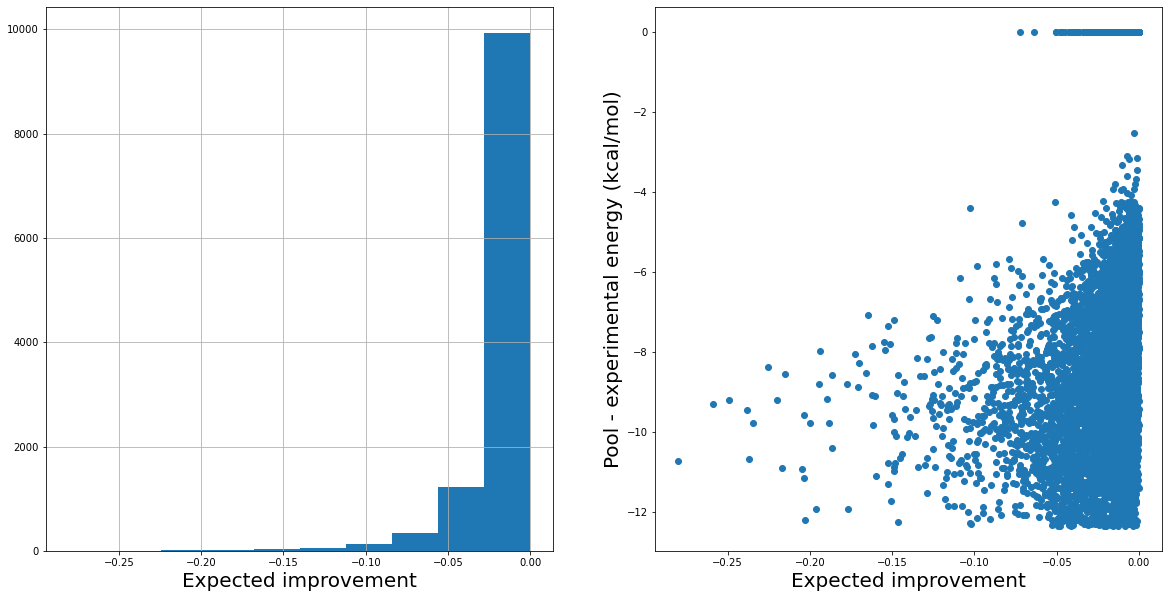

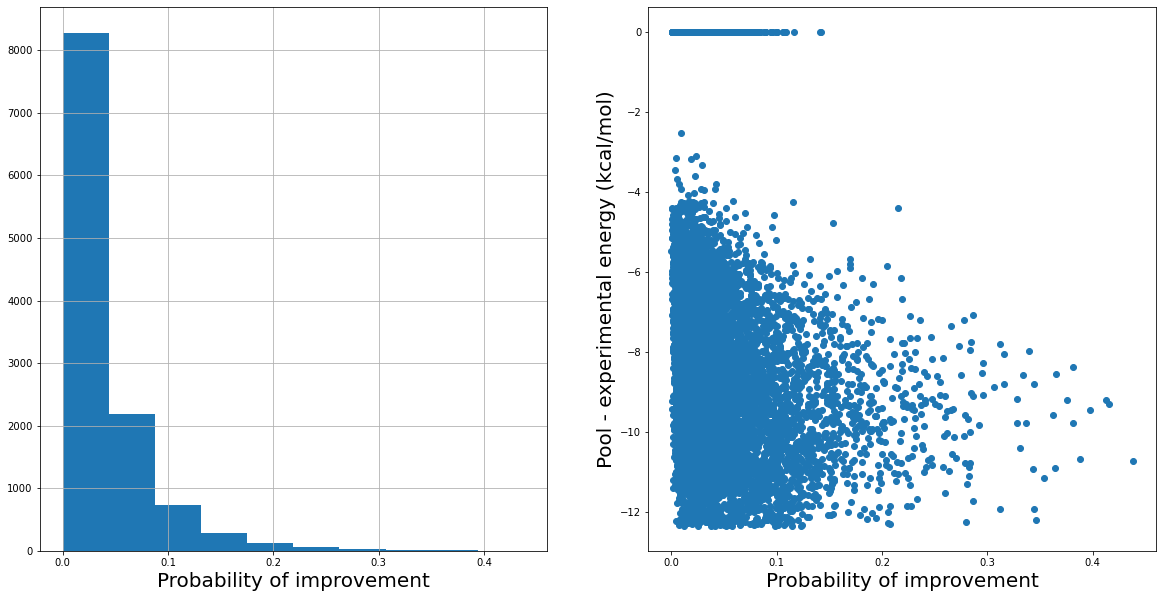

In [59]:
# Show the Expected improvement and Probability of improvement for the initial model

model = get_fitted_model(X_fps[train_ids], y[train_ids])

for ac_fun in ['EI', 'PI']:
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    
    if ac_fun == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Expected improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Expected improvement', fontsize=20)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Probability of improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Probability of improvement', fontsize=20)
    
    axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
    
    plt.show()

Init.
Train:  150
Pool :  11731
Best peptide: -8.473
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
Decoy pep               : 000



1


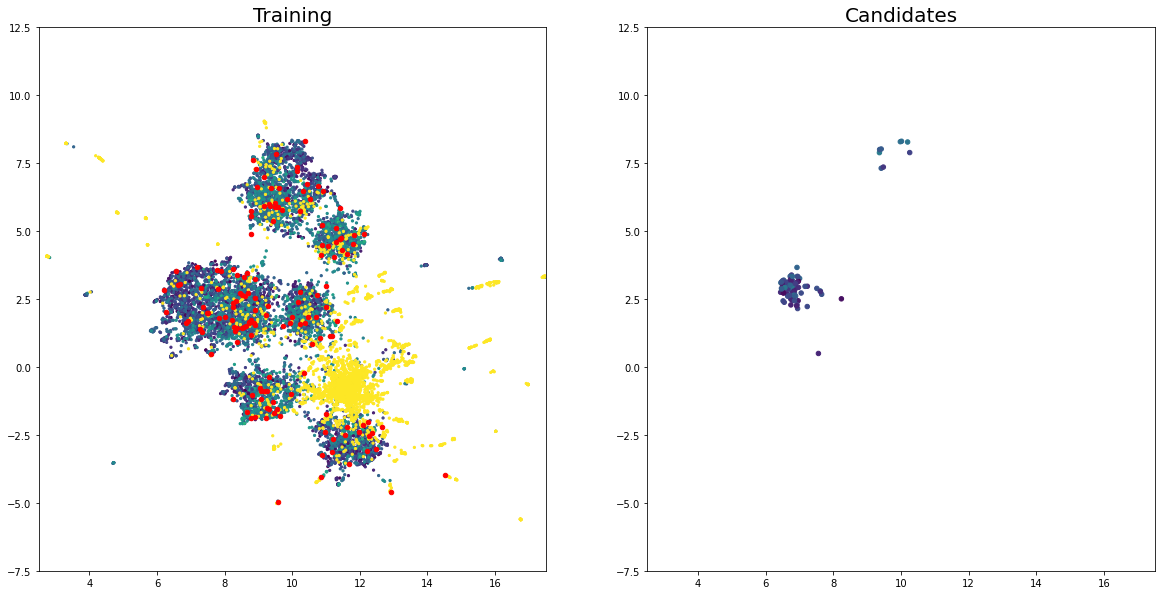

Train:  246
Pool :  11635
Best peptide: -12.245
N pep under -12 kcal/mol: 002 (2.083)
N pep under -11 kcal/mol: 010 (10.417)
N pep under -10 kcal/mol: 034 (35.417)
N pep under -9 kcal/mol: 066 (68.750)
Decoy pep               : 000



2


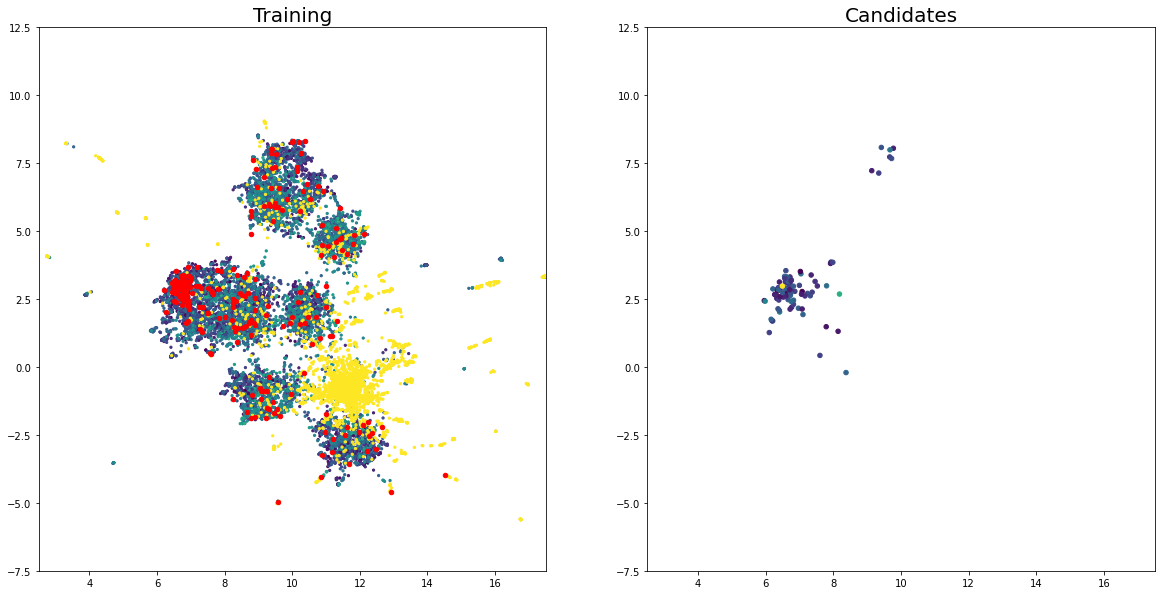

Train:  342
Pool :  11539
Best peptide: -12.292
N pep under -12 kcal/mol: 007 (3.646)
N pep under -11 kcal/mol: 031 (16.146)
N pep under -10 kcal/mol: 073 (38.021)
N pep under -9 kcal/mol: 129 (67.188)
Decoy pep               : 001



3


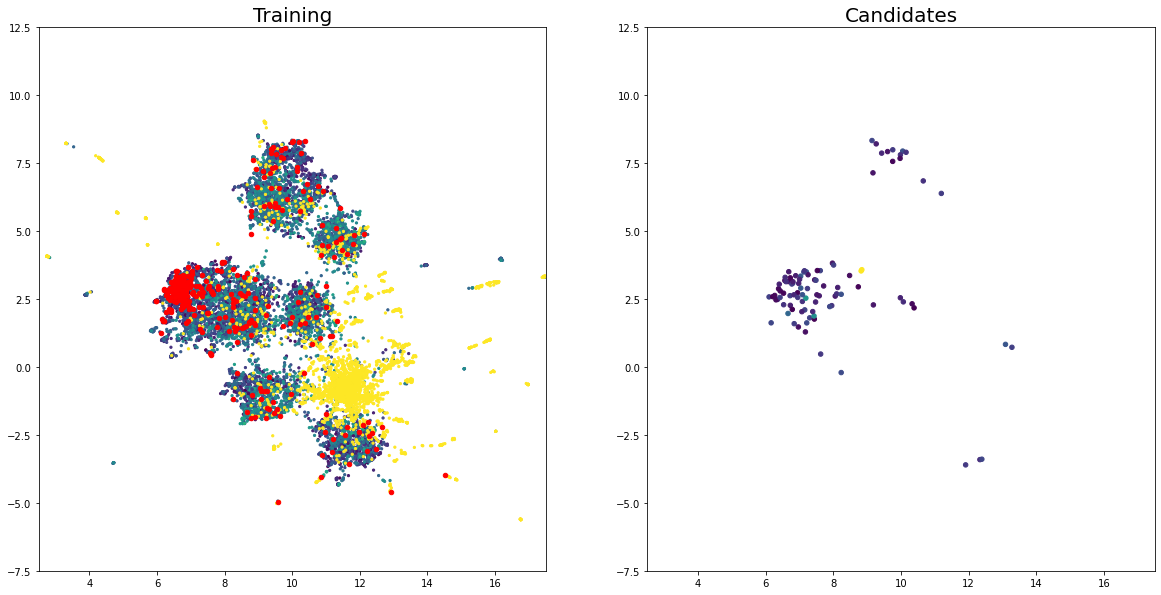

Train:  438
Pool :  11443
Best peptide: -12.334
N pep under -12 kcal/mol: 013 (4.514)
N pep under -11 kcal/mol: 065 (22.569)
N pep under -10 kcal/mol: 134 (46.528)
N pep under -9 kcal/mol: 215 (74.653)
Decoy pep               : 003





In [60]:
n_pep = 96
acq_function = 'PI'

print('Init.')
print('Train: ', X_fps[train_ids].shape[0])
print('Pool : ', X_fps[pool_ids].shape[0])
print('Best peptide: %.3f' % y[train_ids].min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, y[train_ids][y[train_ids] < n].shape[0]))
print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
print('\n\n')

for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps[train_ids], y[train_ids])
    
    if acq_function == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids], xi=0)
        indices = np.argsort(p)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])
        indices = np.argsort(p)[::-1]
    
    # Select candidates
    candidates_ids = pool_ids[indices[:n_pep]]
    
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim(xlim)
    axarr[0].set_ylim(ylim)
    axarr[1].set_xlim(xlim)
    axarr[1].set_ylim(ylim)
    
    plt.show()
    
    # Add candidates to train dataset
    train_ids = np.hstack([train_ids, candidates_ids])
    print('Train: ', train_ids.shape[0])
    
    # Remove candidates from pool
    pool_ids = pool_ids[~np.in1d(pool_ids, candidates_ids)]
    print('Pool : ', pool_ids.shape[0])
    print('Best peptide: %.3f' % y[train_ids].min())
    
    for n in [-12, -11, -10, -9]:
        x = y[train_ids][y[train_ids] < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
    print('\n\n')

## Region selected + Random low affinity binding peptides

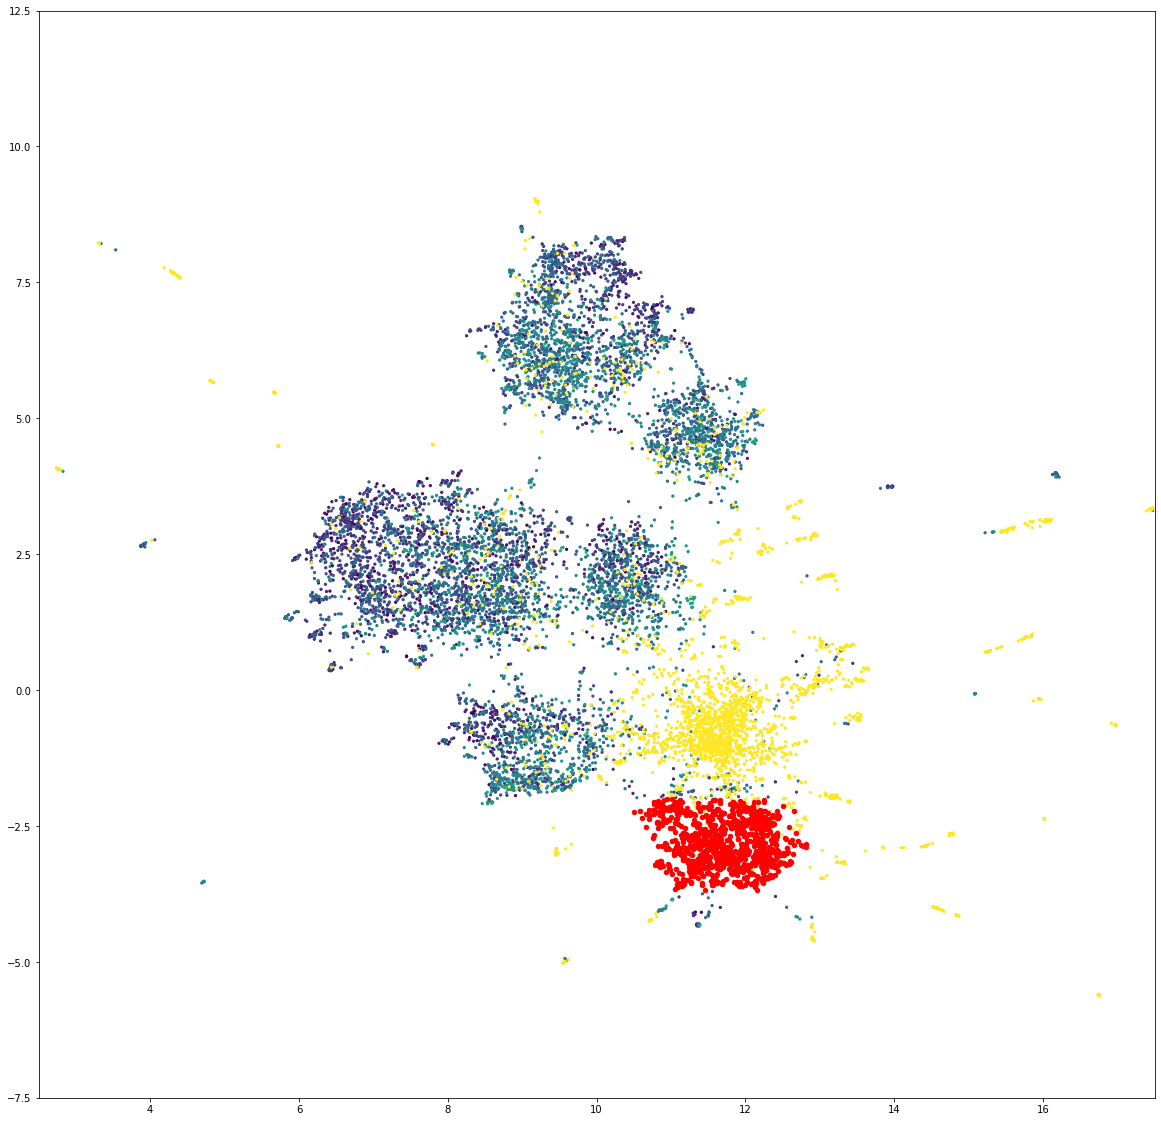

In [100]:
#t = np.hstack(np.argwhere((6 < u[:,0]) & (u[:,0] < 9.5) & (0.5 < u[:,1]) & (u[:,1] < 4.)))
#t = np.hstack(np.argwhere((10.5 < u[:,0]) & (u[:,0] < 13) & (3.5 < u[:,1]) & (u[:,1] < 5.7)))
#t = np.hstack(np.argwhere((9.7 < u[:,0]) & (u[:,0] < 11.4) & (0.8 < u[:,1]) & (u[:,1] < 3.1)))
t = np.hstack(np.argwhere((10.5 < u[:,0]) & (u[:,0] < 13) & (-3.7 < u[:,1]) & (u[:,1] < -2)))

t = t[t < y_exp.shape[0]]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
ax.scatter(u[:,0][t], u[:,1][t], s=20, c='red')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [101]:
# Select n_training (here 150) low affinity binding peptides (energy > -8.5) for the initial training set
# The other peptides will constitute the peptides pool fro, where we will draw the candidates during the otimization

energy_cutoff = -8.5
n_training = 150

low_affinity_ids = np.where(y_exp.numpy() >= energy_cutoff)[0]
high_affinity_ids = np.where(y_exp.numpy() < energy_cutoff)[0]
decoy_ids = np.arange(len(y_exp), len(y_exp) + len(y_decoys))

print('Low affinity : %d' % low_affinity_ids.shape[0])
print('High affinity: %d' % high_affinity_ids.shape[0])
print('Decoys       : %d' % decoy_ids.shape[0])
print('')

# Training ids
train_ids = np.random.choice(t, size=n_training, replace=False)

# Pool ids
low_affinity_ids_leftover = low_affinity_ids[~np.in1d(low_affinity_ids, train_ids)]
pool_ids = np.hstack([high_affinity_ids, low_affinity_ids_leftover, decoy_ids])

print('Train: %06d - %.3f %%' % (train_ids.shape[0], train_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))
print('Pool : %06d - %.3f %%' % (pool_ids.shape[0], pool_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))

Low affinity : 4361
High affinity: 4148
Decoys       : 3372

Train: 000150 - 1.263 %
Pool : 011820 - 99.487 %


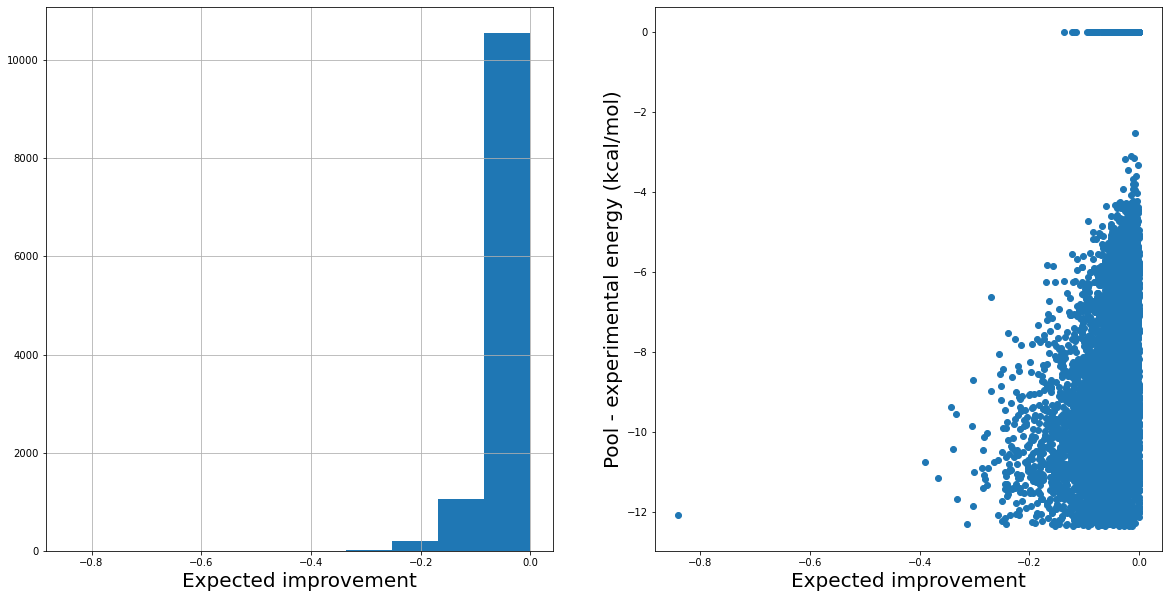

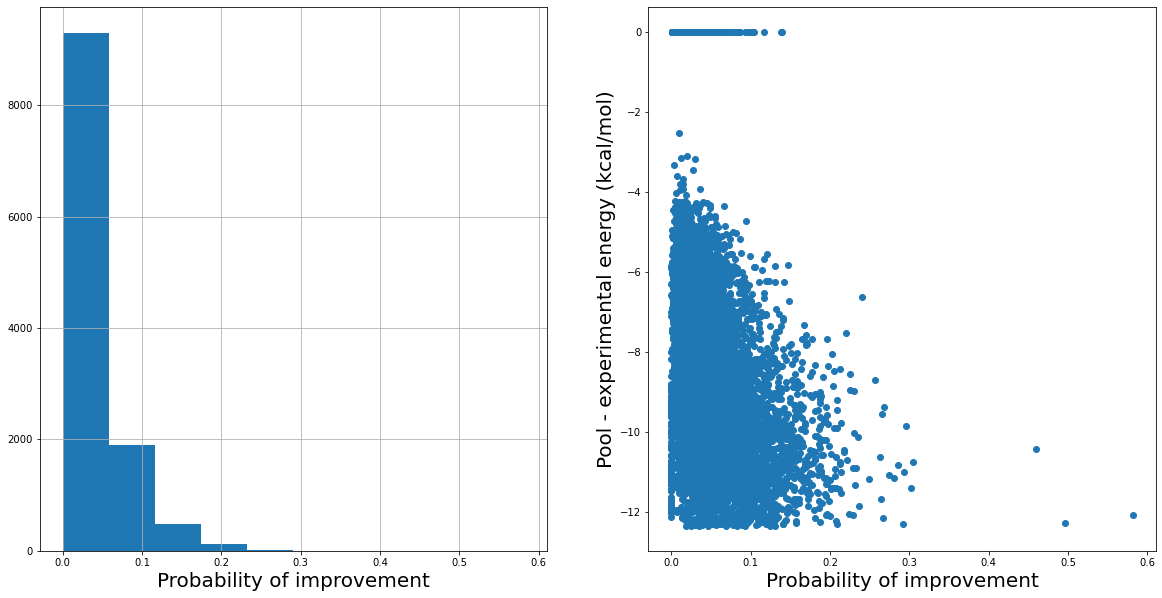

In [102]:
# Show the Expected improvement and Probability of improvement for the initial model

model = get_fitted_model(X_fps[train_ids], y[train_ids])

for ac_fun in ['EI', 'PI']:
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    
    if ac_fun == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Expected improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Expected improvement', fontsize=20)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Probability of improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Probability of improvement', fontsize=20)
    
    axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
    
    plt.show()

Init.
Train:  150
Pool :  11820
Best peptide: -12.261
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 032
N pep under -10 kcal/mol: 055
N pep under -9 kcal/mol: 081
Decoy pep               : 000



1


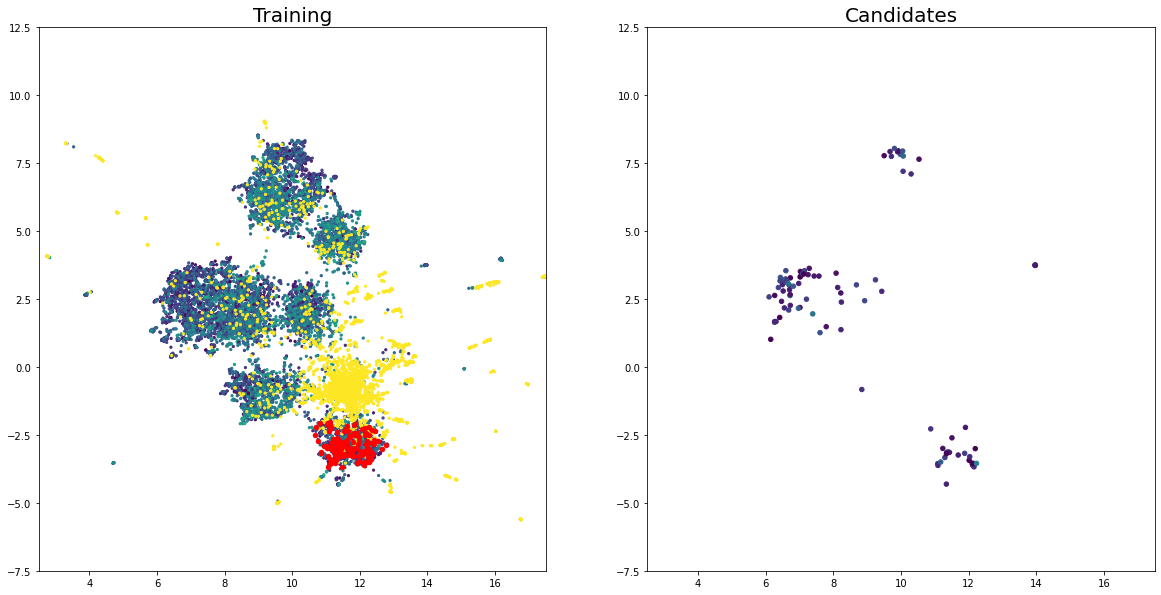

Train:  246
Pool :  11724
Best peptide: -12.296
N pep under -12 kcal/mol: 015 (15.625)
N pep under -11 kcal/mol: 070 (72.917)
N pep under -10 kcal/mol: 119 (123.958)
N pep under -9 kcal/mol: 164 (170.833)
Decoy pep               : 000



2


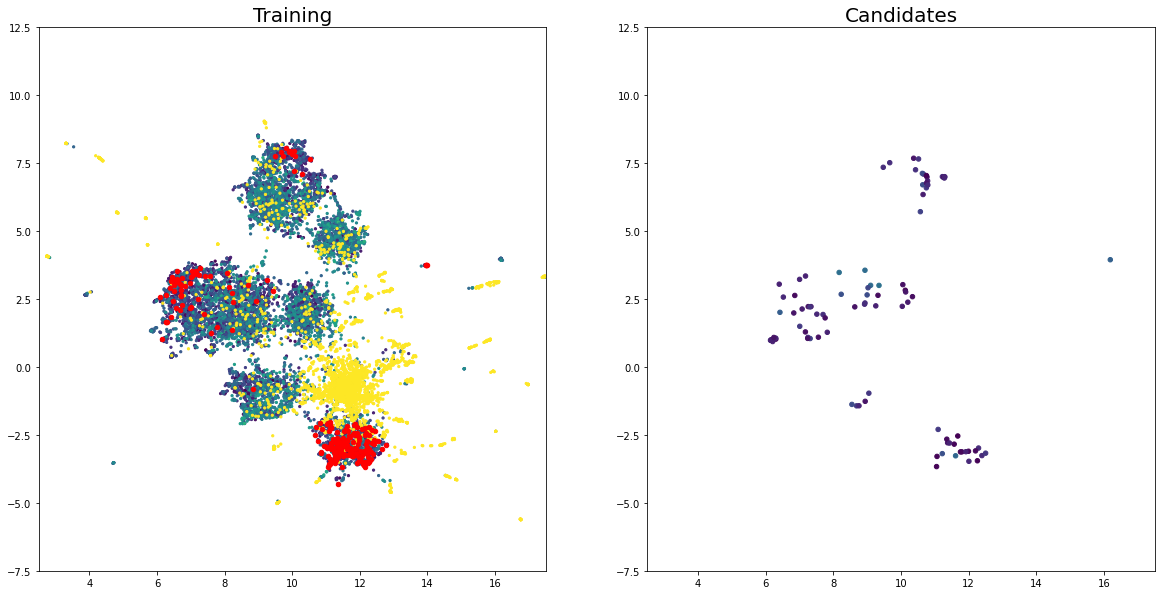

Train:  342
Pool :  11628
Best peptide: -12.296
N pep under -12 kcal/mol: 018 (9.375)
N pep under -11 kcal/mol: 110 (57.292)
N pep under -10 kcal/mol: 195 (101.562)
N pep under -9 kcal/mol: 253 (131.771)
Decoy pep               : 000



3


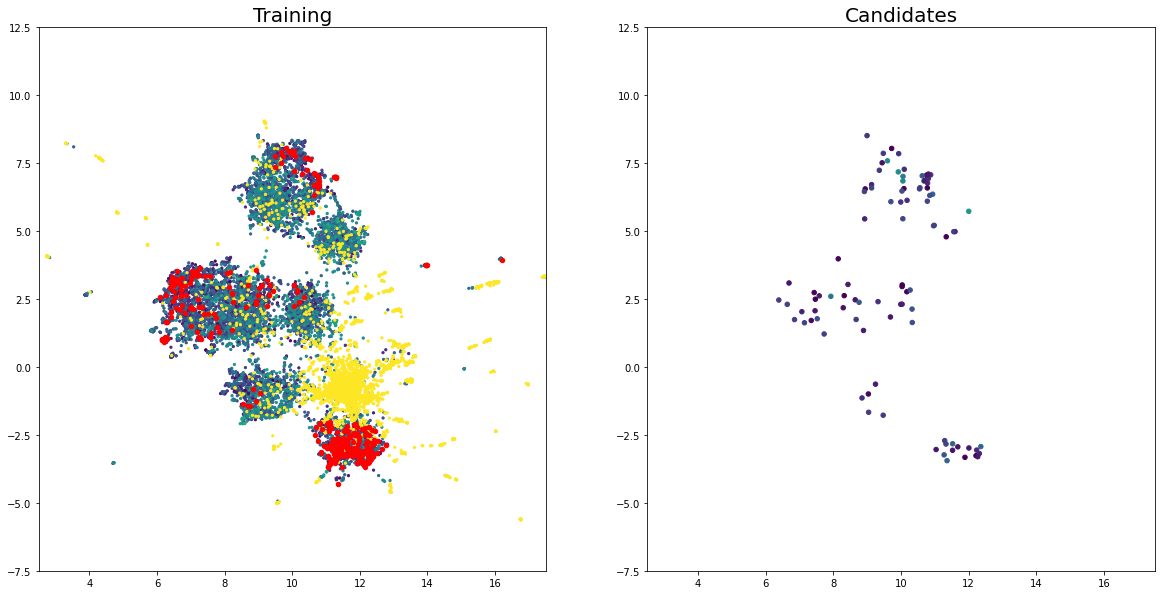

Train:  438
Pool :  11532
Best peptide: -12.341
N pep under -12 kcal/mol: 030 (10.417)
N pep under -11 kcal/mol: 147 (51.042)
N pep under -10 kcal/mol: 252 (87.500)
N pep under -9 kcal/mol: 334 (115.972)
Decoy pep               : 000





In [103]:
n_pep = 96
acq_function = 'PI'

print('Init.')
print('Train: ', X_fps[train_ids].shape[0])
print('Pool : ', X_fps[pool_ids].shape[0])
print('Best peptide: %.3f' % y[train_ids].min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, y[train_ids][y[train_ids] < n].shape[0]))
print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
print('\n\n')

for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps[train_ids], y[train_ids])
    
    if acq_function == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids], xi=0)
        indices = np.argsort(p)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])
        indices = np.argsort(p)[::-1]
    
    # Select candidates
    candidates_ids = pool_ids[indices[:n_pep]]
    
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim(xlim)
    axarr[0].set_ylim(ylim)
    axarr[1].set_xlim(xlim)
    axarr[1].set_ylim(ylim)
    
    plt.show()
    
    # Add candidates to train dataset
    train_ids = np.hstack([train_ids, candidates_ids])
    print('Train: ', train_ids.shape[0])
    
    # Remove candidates from pool
    pool_ids = pool_ids[~np.in1d(pool_ids, candidates_ids)]
    print('Pool : ', pool_ids.shape[0])
    print('Best peptide: %.3f' % y[train_ids].min())
    
    for n in [-12, -11, -10, -9]:
        x = y[train_ids][y[train_ids] < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
    print('\n\n')